In [2]:
################################################################################
"""
This is a Programming Project for Affective, Social Neuroscience (SoSe 2020).
This module provides the predictive modeling for level of immersion based on
 valence and arousal using the dataset" <http://>.

Those are requirement to run this module:
    - python :
    - keras
    - matplotlib
    - numpy
    - pandas
    - pingouin
    - seaborn
    - statsmodels
    - sklearn

This modules consists of three main part:
    - design a label
    - define the data of feature
    - model analysis

We are highly recommend to use the google colab to handle the code.

Authors : Andreea, Bati, JiHoon, and Sofia.
Last-modified : 11th September 2020
"""

! pip install pingouin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.formula.api as smf
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import Input
from keras.utils import to_categorical
from scipy.stats import ttest_ind
from sklearn import svm, linear_model, metrics
sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# for reproducibility
np.random.seed(20201005)

# upload the files at the google colab
from google.colab import files
uploaded = files.upload() # SENT_GROUP_INFO
uploaded2 = files.upload() # SENT_RATING
uploaded3 = files.upload() # SENTECES_ORDER, It's in the ANPP folder

Saving SENT_GROUP_INFO.xlsx to SENT_GROUP_INFO (1).xlsx


Saving SENT_RATING_DATA.xlsx to SENT_RATING_DATA (1).xlsx


Saving SENTENCES_ORDER.xlsx to SENTENCES_ORDER (1).xlsx


Index(['CASE', 'TEXT', 'CONDITION', 'QESTN_LANGUAGE', 'DEVICE',
       'BFI_EXTRAVERSION', 'BFI_AGREEABLENESS', 'BFI_CONSCIENTIOUSNESS',
       'BFI_NEUROTICISM', 'BFI_OPENNESS', 'PANAS_PA', 'PANAS_NA',
       'FOCUSING_OF_ATTENTION', 'TEXT_ABSORPTION', 'IMAGINABILITY',
       'SPATIAL_INVOLVEMENT', 'RECEPTION_TERMINATION', 'SUSPENSE',
       'EMOTIONAL_INVOLVEMENT', 'GENERAL_READING_ENJOYMENT', 'IDENTIFICATION',
       'PARASOCIAL_INTERACTION', 'COGNITIVE_INVOLVEMENT', 'THEMATIC_INTEREST',
       'ANALYTICAL_RECEPTION', 'EASE_OF_COGNITIVE_ACCESS',
       'ATTENTION_CHECKS_COUNT_WRONG_ANSWERS',
       'ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS', 'KNOWLEDGE_OF_THE_STORY',
       'READING_FOR_PLEASURE', 'LIKING_OF_READING', 'SOURCE_OF_KNOWLEDGE',
       'DEG_TIME'],
      dtype='object')
Index(['CASE', 'TEXT', 'CONDITION', 'LANGUAGE', 'PAGE_TIME', 'SENTENCE_NUMBER',
       'AROUSAL_RATING', 'VALENCE_RATING'],
      dtype='object')
    CASE   TEXT  CONDITION  ... LIKING_OF_READING    SOURCE_

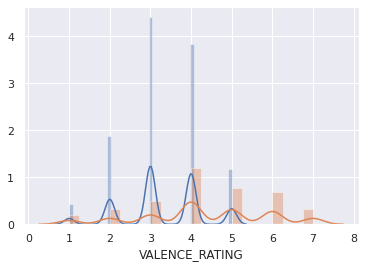

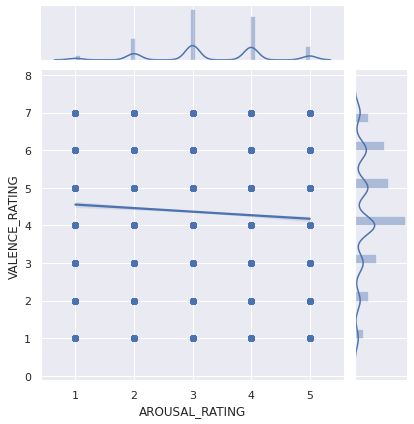

In [4]:
################################################################################
#              PART I: Exploratory Data Analysis and Data Cleaning
################################################################################
"""
# ATTENTION_CHECKS_COUNT_WRONG_ANSWERS
# ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS
# DEG_TIME
# Can be an option of exclusion

# 14's readers response, literature reviews are pending
# KNOWLEDGE_OF_THE_STORY, fiction feeling hypothesis
# SOURCE_OF_KNOWLEDGE, fiction feeling hypothesis
# Can be an option of level of immersion

# DEVICE
# READING_FOR_PLEASURE
# LIKING_OF_READING
# Can be an option of both exclusion and immersion
"""
################################################################################
#                          Exploratory Data Analysis
################################################################################
"""
Exploartory Data Analysis
Please fill out why you decide to do further below steps based on which data.
Such as "the data distribution told us that we need to exclude that part.
"""
# Bring the candidate factors in the dataset
sg_factors = "B:E,J,AE:AI,BE,BF,CW:DJ,DM,DN,DP,EC,EE,EF,FN"

# Load the factors datasets
s_group = pd.read_excel('SENT_GROUP_INFO.xlsx', usecols = sg_factors)
s_rating = pd.read_excel('SENT_RATING_DATA.xlsx')

# Check the index of the senetence_group
print(s_group.columns)
print(s_rating.columns)
# Display the table
print(s_group)
print(s_rating)
s_group
s_rating

s_rating_filtered = s_rating.filter(["TEXT", "CONDITION", "SENTENCE_NUMBER", "VALENCE_RATING", "AROUSAL_RATING"])
# Univariate distribution of the mean of Arousal Ratings
sns.distplot(s_rating_filtered["AROUSAL_RATING"])
# Univariate distribution of the mean of Recoded Valence Ratings
sns.distplot(s_rating_filtered['VALENCE_RATING'])
# Joint plot of the means of both vazlence and arousal
sns.jointplot(x='AROUSAL_RATING',y='VALENCE_RATING',data = s_rating_filtered,kind='reg')

CASE                                       0
TEXT                                       0
CONDITION                                  0
QESTN_LANGUAGE                             0
DEVICE                                     0
BFI_EXTRAVERSION                           0
BFI_AGREEABLENESS                          0
BFI_CONSCIENTIOUSNESS                      0
BFI_NEUROTICISM                            0
BFI_OPENNESS                               0
PANAS_PA                                   0
PANAS_NA                                   0
FOCUSING_OF_ATTENTION                      0
TEXT_ABSORPTION                            0
IMAGINABILITY                              0
SPATIAL_INVOLVEMENT                        0
RECEPTION_TERMINATION                      0
SUSPENSE                                   0
EMOTIONAL_INVOLVEMENT                      0
GENERAL_READING_ENJOYMENT                  0
IDENTIFICATION                             0
PARASOCIAL_INTERACTION                     0
COGNITIVE_

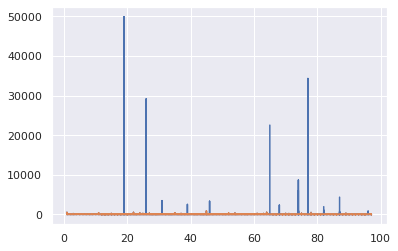

In [5]:
################################################################################
#                               Data cleaning
################################################################################
"""
COMMENT:
DEG_TIME, CASE: 34, 36 (>100)
ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS: 96, 26, 34 (<2)
PAGE_TIME, CASE: 19, 26, 31, 39, 46, 65, 68, 74, 77, 82, 87 (> 1000)
b_list: 19, 26, 31, 34, 36, 39, 46, 65, 68, 74, 77, 82, 87, 96 (N=14)

DATASET:
e_group, group_info_dataset
e_rating, group_rating_dataset
"""
# SENT_GROUP_INFO
# Check the NaN in both the s_group and the s_rating
print(s_group.isnull().sum())
print(s_rating.isnull().sum())
plt.plot(s_rating['CASE'], s_rating['PAGE_TIME'])

# Save the CASE exclusion list
b_DEG = s_group.loc[s_group['DEG_TIME']>100]['CASE']
# print(b_DEG)
b_ATT = s_group.loc[s_group['ATTENTION_CHECKS_COUNT_CORRECT_ANSWERS']<2]['CASE']
# print(b_ATT)
b_PAG = s_rating.loc[s_rating['PAGE_TIME']>999]['CASE']
# print(b_PAG)

# Concatenate the bad data list
b_list = pd.concat([b_DEG, b_ATT, b_PAG], axis = 0)
# print(b_list)

# Delete the duplicates and make a list
b_list = b_list.drop_duplicates()
# print(b_list)

# Convert list
b_case = list(b_list.values)
print(b_case)

# Excluded the bad case from the dataset
e_group = []
e_rating = []
a_group = s_group.copy()
a_rating = s_rating.copy()

for i in b_case:
    a_rating = a_rating.drop(a_rating[a_rating['CASE'] == i].index)
    a_group = a_group.drop(a_group[a_group['CASE'] == i].index)
    if i == 46:
        e_group = a_group
        e_rating = a_rating

print(e_group)
print(e_rating)
plt.plot(e_rating['CASE'], e_rating['PAGE_TIME'])

   CASE   TEXT  CONDITION  ...    SOURCE_OF_KNOWLEDGE DEG_TIME  IMMERSION
0     1  HARRY  SCRAMBLED  ...             BOOK, FILM       50   4.125000
1     2  HARRY  SCRAMBLED  ...             BOOK, FILM       15   5.017857
2     3  HARRY   COHERENT  ...  BOOK, FILM, AUDIOBOOK       13   5.303571
3     4  HARRY   COHERENT  ...             BOOK, FILM       18   4.065476
4     5  HARRY   COHERENT  ...                    NaN       14   2.327381
5     6  HARRY   COHERENT  ...                   FILM        8   4.071429
6     7  HARRY   COHERENT  ...             BOOK, FILM       10   4.488095
7     8  HARRY   COHERENT  ...  BOOK, FILM, AUDIOBOOK       13   5.375000
8     9  HARRY   COHERENT  ...                   BOOK       18   4.279762
9    10  HARRY   COHERENT  ...             BOOK, FILM        7   4.321429

[10 rows x 34 columns]


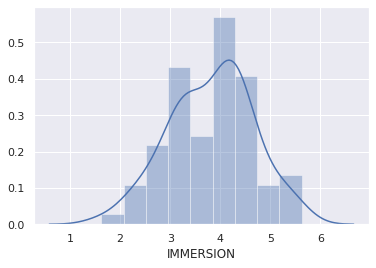

In [6]:
################################################################################
#               PART II: Design the label, level fo immersion
################################################################################
"""
Reivew the references are pending.

I. Can be applied the knowledge of the source, number of the source as count:
1, 2, 3

II. Design the level of immersion using multiplying:
log((1+value1)*(1+value2))

Check the caution code below:
"""
# Create the new column of 'IMMERSION'
e_group['IMMERSION'] = 0

# Sum the readers response
for i in range (14):
    e_group['IMMERSION'] += e_group.iloc[:,i+12]

# Using the mean of the reader's response
e_group['IMMERSION']=e_group['IMMERSION']/14
print(e_group.head(10))
sns.distplot(e_group["IMMERSION"])

FOCUSING_OF_ATTENTION
R2:  0.2830878019229618
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     31.98
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.26e-07
Time:                        22:59:59   Log-Likelihood:                -88.491
No. Observations:                  83   AIC:                             181.0
Df Residuals:                      81   BIC:                             185.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

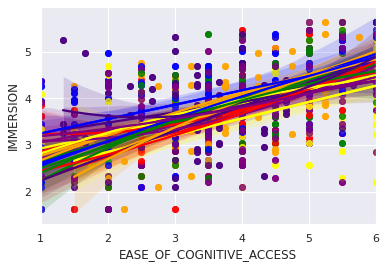

In [7]:
################################################################################
#         PART III: Statistical Analysis Immersion with other variable
################################################################################
"""
Test the correlation between IMMERSION and each of Reading Experience,
 and check the statistic significance
"""
################################################################################
# Statistical Analysises between Immersion and 14 Reading Experience: Mean case
# Using linear regression, oridnary least square

r_list = []
for i in range(14):
  r_list.append(e_group.columns[i+12])

def immersion_re_sa(r_list):
    for i, rr in enumerate(r_list):
        r_list = 'IMMERSION ~ '+ rr
        res = smf.ols(formula = r_list, data = e_group).fit()
        print(rr)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_re_pl(r_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, rr in enumerate(r_list):    
        sns.regplot(x = rr, y="IMMERSION", data = e_group, color = color[i])

def immersion_re_pl2(r_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, rr in enumerate(r_list):    
        sns.regplot(x = rr, y = "IMMERSION", data = e_group, color = color[i], order = 2)

immersion_re_sa(r_list)
immersion_re_pl(r_list)
immersion_re_pl2(r_list)

BFI_EXTRAVERSION
R2:  0.0038297705761805023
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.3114
Date:                Mon, 14 Sep 2020   Prob (F-statistic):              0.578
Time:                        23:00:04   Log-Likelihood:                -102.14
No. Observations:                  83   AIC:                             208.3
Df Residuals:                      81   BIC:                             213.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

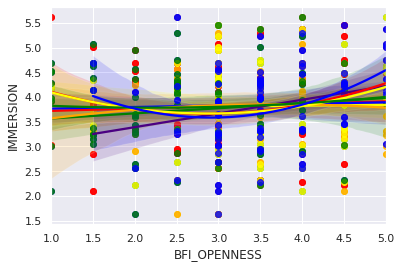

In [8]:
################################################################################
# Statistical Analysises between Immersion and 5 BFI: Mean case
# Using linear regression, oridnary least square

bfi_list = []
for i in range(5):
  bfi_list.append(e_group.columns[i+5])

def immersion_bfi_sa(bfi_list):
    for i, bfi in enumerate(bfi_list):
        bfi_list = 'IMMERSION ~ '+ bfi
        res = smf.ols(formula =bfi_list, data = e_group).fit()
        print(bfi)
        print('R2: ', res.rsquared)
        print(res.summary())
        print('')

def immersion_bfi_pl(bfi_list):
    color = ['red','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y="IMMERSION", data = e_group, color = color[i])

def immersion_bfi_pl2(bfi_list):
    color = ['red','orange','yellow','green','blue','indigo','purple',
             'red','orange','yellow','green','blue','indigo','purple']
    for i, bfi in enumerate(bfi_list):    
        sns.regplot(x = bfi, y = "IMMERSION", data = e_group, color = color[i], order = 2)

immersion_bfi_sa(bfi_list)
immersion_bfi_pl(bfi_list)
immersion_bfi_pl2(bfi_list)

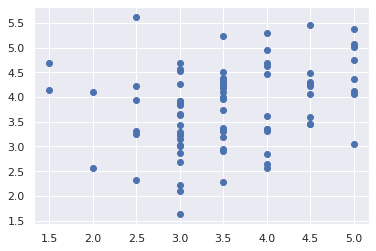

In [9]:
################################################################################
x = e_group['BFI_OPENNESS']
y = e_group['IMMERSION']
# print(x)
# print(y)
plt.scatter(x,y)

BFI_OPENESS
                            OLS Regression Results                            
Dep. Variable:              IMMERSION   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     6.439
Date:                Mon, 14 Sep 2020   Prob (F-statistic):             0.0131
Time:                        23:00:06   Log-Likelihood:                -99.128
No. Observations:                  83   AIC:                             202.3
Df Residuals:                      81   BIC:                             207.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8366      0.398  

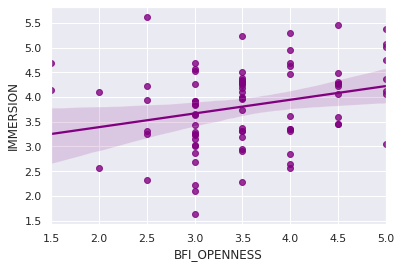

In [10]:
################################################################################
# IMMERSION AND BFI OPENNESS
"""
7%, p-value < 0.05: candidate as the input data
"""
# Using linear regression, oridnary least square
res = smf.ols(formula='IMMERSION ~ BFI_OPENNESS', data = e_group).fit()
sns.regplot(x="BFI_OPENNESS", y="IMMERSION", data=e_group, color='purple')
print('BFI_OPENESS')
print(res.summary())

BFI_OPENESS


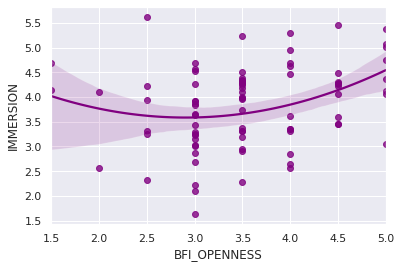

In [11]:
################################################################################
# IMMERSION AND BFI OPENNESS
# Plot the non-linear

sns.regplot(x="BFI_OPENNESS", y="IMMERSION",
            data = a_group, order = 2, color = 'purple')
print('BFI_OPENESS')

In [12]:
################################################################################
#                    PART IV: Model based data analysis
################################################################################
"""
"""
################################################################################
#                  Preprocess the dataset: group selection
################################################################################
"""
rh_eng, rating_harry_english (Coherent) dataset
rh_ger, rating_harry_german (Coherent) dataset
rp_eng, rating_pippi_english (Coherent) dataset 
rp_ger, rating_pippi_german (Coherent) dataset

lh_eng, label_harry_english (Coherent) dataset
lh_ger, label_harry_german (Coherent) dataset
lp_eng, label_harry_english (Coherent) dataset
lp_ger, label_harry_german (Coherent) dataset
"""
###############################################################################
# Load the label related dataset
ld = e_group.loc[:, ['CASE','TEXT','CONDITION','QESTN_LANGUAGE',
                     'BFI_OPENNESS','IMMERSION']]
print(ld.shape, 'Total')

# lh = ld.loc[ld['TEXT']=='HARRY']
# Load the harry - coherent related dataset
print("Coherent, Sent Group Dataset for Label")
lh = ld.loc[ld['TEXT']=='HARRY'].loc[ld['CONDITION']=='COHERENT']
print(lh.shape, 'Coherent Text, Harry')
lh_eng = lh.loc[lh['QESTN_LANGUAGE']=='ENG']
lh_ger = lh.loc[lh['QESTN_LANGUAGE']=='GER']

# Load the pippi - coherent related group dataset
# lp = ld.loc[ld['TEXT']=='PIPPI']
lp = ld.loc[ld['TEXT']=='PIPPI'].loc[ld['CONDITION']=='COHERENT']
print(lp.shape, 'Coherent Text, Pipi')
lp_eng = lp.loc[lp['QESTN_LANGUAGE']=='ENG']
lp_ger = lp.loc[lp['QESTN_LANGUAGE']=='GER']


print(lh_eng.shape, 'Harry, ENG')
print(lh_ger.shape, 'Harry, GER')
print(lp_eng.shape, 'Pippi, ENG')
print(lp_ger.shape, 'Pippy, GER')

################################################################################
# Load the rating related group dataset
rd = e_rating.loc[:, ['CASE','TEXT','CONDITION','LANGUAGE',"SENTENCE_NUMBER",
                      'AROUSAL_RATING','VALENCE_RATING']]
print(rd.shape, 'Total')

# rh = rd.loc[rd['TEXT']=='HARRY']
# Load the harry related rating dataset
print('Sent Rating Dataset for Input')
rh = rd.loc[rd['TEXT']=='HARRY'].loc[rd['CONDITION']=='COHERENT']
print(rh.shape, 'Coherent Text, Harry')
rh_eng = rh.loc[rh['LANGUAGE']=='ENG']
rh_ger = rh.loc[rh['LANGUAGE']=='GER']

# Load the pippi related rating dataset
# rp = rd.loc[rd['TEXT']=='PIPPI']
rp = rd.loc[rd['TEXT']=='PIPPI'].loc[rd['CONDITION']=='COHERENT']
print(rp.shape, 'Coherent Text, Pippi')

# Delete the NAN dataset
rp_eng = rp.loc[rp['LANGUAGE']=='ENG'].dropna(axis=0)
rp_ger = rp.loc[rp['LANGUAGE']=='GER'].dropna(axis=0)

# Check the NaN dataset
print(rh_eng.shape, 'ENG')
print(rh_eng.isnull().sum(), 'NaN')
print(rh_ger.shape, 'GER')
print(rh_ger.isnull().sum(), 'NaN')

# Check the NaN dataset
print(rp_eng.shape, 'ENG')
print(rp_eng.isnull().sum(), 'NaN')
print(rp_ger.shape, 'GER')
print(rp_ger.isnull().sum(), 'NaN')

(83, 6) Total
Coherent, Sent Group Dataset for Label
(26, 6) Coherent Text, Harry
(18, 6) Coherent Text, Pipi
(17, 6) Harry, ENG
(9, 6) Harry, GER
(13, 6) Pippi, ENG
(5, 6) Pippy, GER
(10953, 7) Total
Sent Rating Dataset for Input
(3250, 7) Coherent Text, Harry
(2556, 7) Coherent Text, Pippi
(2125, 7) ENG
CASE               0
TEXT               0
CONDITION          0
LANGUAGE           0
SENTENCE_NUMBER    0
AROUSAL_RATING     0
VALENCE_RATING     0
dtype: int64 NaN
(1125, 7) GER
CASE               0
TEXT               0
CONDITION          0
LANGUAGE           0
SENTENCE_NUMBER    0
AROUSAL_RATING     0
VALENCE_RATING     0
dtype: int64 NaN
(1729, 7) ENG
CASE               0
TEXT               0
CONDITION          0
LANGUAGE           0
SENTENCE_NUMBER    0
AROUSAL_RATING     0
VALENCE_RATING     0
dtype: int64 NaN
(680, 7) GER
CASE               0
TEXT               0
CONDITION          0
LANGUAGE           0
SENTENCE_NUMBER    0
AROUSAL_RATING     0
VALENCE_RATING     0
dtype: int64 

In [25]:
################################################################################
#                     Preprocess the dataset: Dataset
################################################################################
"""
anpp_dataset, coherent eng+ger with harry
Input data: VALENCE(1-7), AROUSAL(1-5), and BFI_OPENESS(1-5)
Output data: Immersion(1-6)

# Dataset
# Training set: 20(Harry:ENG13+GER7)
# Test set: 6(Harry:ENG4+GER2)
"""
################################################################################
# Load the coherent case number
ch_eng = list(lh_eng.loc[:,['CASE']]['CASE'])
ch_ger = list(lh_ger.loc[:,['CASE']]['CASE'])
# print(ch_eng)
# print(ch_ger)

# Training set, Test set Case Number
tr_case = ch_eng[:13] + ch_ger[:7]
te_case = ch_eng[13:] + ch_ger[7:]
# print(tr_case)
# print(te_case)

# Concatenate ENG and GER Harry coherent dataset
lh_set = pd.concat([lh_eng, lh_ger], axis = 0)
# print(lh_set)

# Prepare the label dataset

# Extract only Immersion data
train_label = []
test_label = []

case = [tr_case, te_case]
for i in case:
    for j in i:
        if i == tr_case:
            train_label.append(list(lh_set[lh_set['CASE']==j]['IMMERSION']))
        else:
            test_label.append(list(lh_set[lh_set['CASE']==j]['IMMERSION']))

# print(train_label)
# print(test_label)

################################################################################
# Prepare the data dataset

# Extract only BFI_Openness
train_bfi = []
test_bfi = []

for i in case:
    for j in i:
        if i == tr_case:
            train_bfi.append(list(lh_set[lh_set['CASE']==j]['BFI_OPENNESS']))
        else:
            test_bfi.append(list(lh_set[lh_set['CASE']==j]['BFI_OPENNESS']))

# print(train_bfi)
# print(test_bfi)

# Load the coherent harry sentence order
sentences_order = pd.read_excel('SENTENCES_ORDER.xlsx')
order = sentences_order.loc[:,['SURVEY_ORDER']]['SURVEY_ORDER']
oh_lang = list(order)
print(oh_lang)

# Concatenate ENG and GER Harry coherent dataset
rh_set = pd.concat([rh_eng, rh_ger], axis = 0)
# print(rh_set)

# Extract both Arousal and Valence

train_arousal = []
train_valence = []
test_arousal = []
test_valence = []

for i in case:
    for j in i:
        if i == tr_case:
            set = rh_set[rh_set['CASE']==j]
            set['SURVEY_ORDER'] = oh_lang
            new = set.sort_values(by='SURVEY_ORDER')
            train_arousal.append(list(new.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            train_valence.append(list(new.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
        else:
            set = rh_set[rh_set['CASE']==j]
            set['SURVEY_ORDER'] = oh_lang
            new = set.sort_values(by='SURVEY_ORDER')
            test_arousal.append(list(new.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            test_valence.append(list(new.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))

# Dataset as a list
print('Dataset')
print('Training set')
print(train_bfi)
print(train_arousal)
print(train_valence)
print(train_label)
print('Test set')
print(test_bfi)
print(test_arousal)
print(test_valence)
print(test_label)

# Label dataset continuous label to dicrete label
dis_train_label = []
dis_test_label = []
label = [train_label, test_label]

for i in label:
    for j in i:
        if i == train_label:
            if j[0] >= 5:
                dis_train_label.append(5)
            elif j[0] >= 4:
                dis_train_label.append(4)
            elif j[0] >= 3:
                dis_train_label.append(3)
            elif j[0] >= 2:
                dis_train_label.append(2)
            else:
                dis_train_label.append(1)
        else:
            if j[0] >= 5:
                dis_test_label.append(5)
            elif j[0] >= 4:
                dis_test_label.append(4)
            elif j[0] >= 3:
                dis_test_label.append(3)
            elif j[0] >= 2:
                dis_test_label.append(2)
            else:
                dis_test_label.append(1)

# Check the discrete label dataset
print(train_label, 'train')
print(dis_train_label, 'discrete')
print(test_label, 'test')
print(dis_test_label, 'discrete')

# Dataset as np.array
tr_bfi = np.array(train_bfi)
tr_arousal = np.array(train_arousal)
tr_valence = np.array(train_valence)
tr_label = np.array(train_label)
te_bfi = np.array(test_bfi)
te_arousal = np.array(test_arousal)
te_valence = np.array(test_valence)
te_label = np.array(test_label)

print('Dataset')
print('Training set')
print(tr_bfi)
print(tr_arousal)
print(tr_valence)
# print(tr_label)
print('Test set')
print(te_bfi)
print(te_arousal)
print(te_valence)
# print(te_label)

################################################################################
# Concatenate to design flatten (1,) dataset
print(tr_bfi.shape)
print(tr_arousal.shape)
print(tr_valence.shape)
print(te_bfi.shape)
print(te_arousal.shape)
print(te_valence.shape)

tr_dataset = np.concatenate((tr_bfi, tr_arousal, tr_valence), axis = 1)
te_dataset = np.concatenate((te_bfi, te_arousal, te_valence), axis = 1)
print(tr_dataset)
print(tr_dataset.shape,'tr_dataset')
print(te_dataset)
print(te_dataset.shape,'te_dataset')


################################################################################
# Design the (3,) datset
train_data = [train_bfi, train_arousal, train_valence]
test_data = [test_bfi, test_arousal, test_valence]
print(train_data)
print(len(train_data), 'train_data_shape')
print(len(test_data), 'test_data_shape')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 55, 102, 98, 48, 56, 59, 78, 79, 80, 81, 25, 34, 46]
Dataset
Training set
[[4.0], [3.0], [3.0], [3.0], [4.5], [3.5], [4.0], [1.5], [5.0], [5.0], [5.0], [4.5], [3.0], [4.0], [4.5], [2.5], [5.0], [4.5], [5.0], [4.5]]
[[2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(20, 1)
(20, 125)
(20, 125)
(6, 1)
(6, 125)
(6, 125)
(20, 251)
(6, 251)
(20, 251, 1)
(6, 251, 1)
(20, 1)
(6, 1)
processing fold #: 0


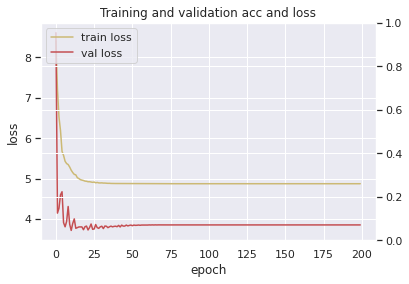

processing fold #: 1


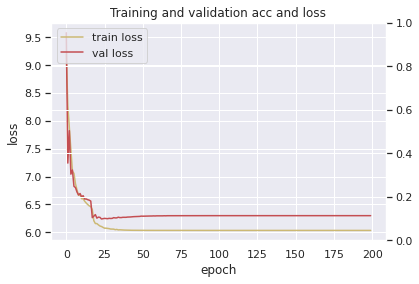

processing fold #: 2


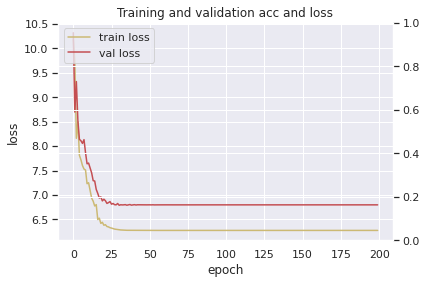

processing fold #: 3


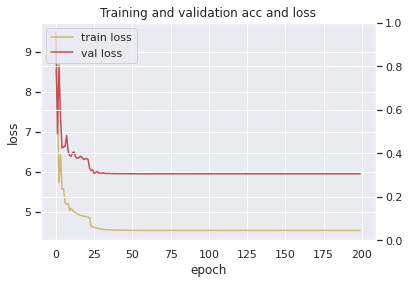

exprected_value 2.749493718147278 real_value [3.23214286]
exprected_value 2.733986482620239 real_value [3.1547619]
exprected_value 2.535129508972168 real_value [5.23809524]
exprected_value 2.668456988334656 real_value [4.14285714]
exprected_value 3.494284372329712 real_value [4.32142857]
exprected_value 3.0468636989593505 real_value [3.86309524]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


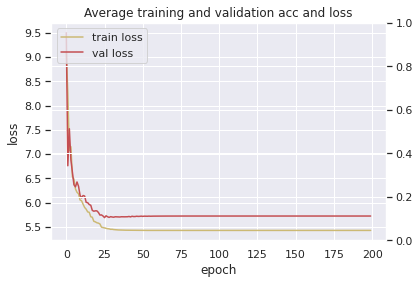

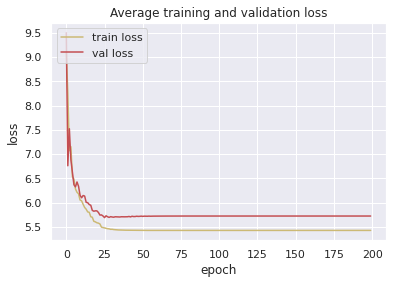

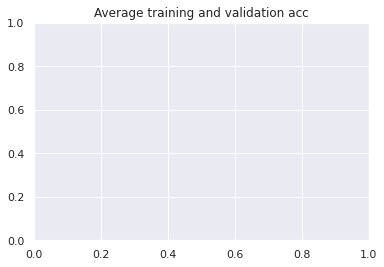

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 250, 64)           192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                400050    
Total params: 400,242
Trainable params: 400,242
Non-trainable params: 0
_________________________________________________________________


In [14]:
import numpy
print(tr_bfi.shape)
print(tr_arousal.shape)
print(tr_valence.shape)
print(te_bfi.shape)
print(te_arousal.shape)
print(te_valence.shape)

print(tr_dataset.shape)
print(te_dataset.shape)
tr_cnn_data = numpy.expand_dims(tr_dataset,axis=2)
te_cnn_data = numpy.expand_dims(te_dataset,axis=2)
print(tr_cnn_data.shape)
print(te_cnn_data.shape)

print(tr_label.shape)
print(te_label.shape)

################################################################################
# : Neural network (1D convolutional neural network), Sequential, Categorical
################################################################################
"""
Pending, CNN 1D technique and RNN applied

BFI_OPENNESS 251 generation needed

20trainingset, 251values, 1dimension
(20x251x1)
"""
# Dataset
# Training set: 20(Harry:ENG13+GER7)
# Test set: 6(Harry:ENG4+GER2)

train_data = tr_cnn_data.copy()
test_data = te_cnn_data.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

def build_model():
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu',
                           input_shape=(251,1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.compile(optimizer='adam',loss='mse')
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []
all_val_acc_histories = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_label = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_label = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data=(val_data, val_label),
                        epochs = num_epochs, batch_size=5, verbose=0)

    # Shows the acc and loss plot
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    plt.title('Training and validation acc and loss')
    loss_ax.plot(history.history['loss'],'y',label = 'train loss')
    loss_ax.plot(history.history['val_loss'],'r',label = 'val loss')

    #acc_ax.plot(history.history['acc'],'b',label = 'train acc')
    #acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc = 'upper left')
    #acc_ax.legend(loc = 'lower left')
    plt.show()

    # Save the histories: acc, loss, val_acc, and val_loss
    #all_acc_histories.append(history.history['acc'])
    all_loss_histories.append(history.history['loss'])
    #all_val_acc_histories.append(history.history['val_acc'])
    all_val_loss_histories.append(history.history['val_loss'])

result = model.predict(test_data, verbose=0)
for i, e in enumerate(result):
    print("exprected_value",sum(e,0.0)/len(e), "real_value", test_label[i])
#print( result)
#print(test_label)

# Compute the average histories
average_acc_history = [
            np.mean([x[i] for x in all_acc_histories])
            for i in range(num_epochs)]
average_loss_history = [
            np.mean([x[i] for x in all_loss_histories]) 
            for i in range(num_epochs)]
average_val_acc_history = [
            np.mean([x[i] for x in all_val_acc_histories]) 
            for i in range(num_epochs)]
average_val_loss_history = [
            np.mean([x[i] for x in all_val_loss_histories]) 
            for i in range(num_epochs)]

# Shows the average acc and loss plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
plt.title('Average training and validation acc and loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'upper left')
#acc_ax.legend(loc = 'lower left')
plt.show()

# Shows the average loss plot
fig, loss_ax = plt.subplots()
plt.title('Average training and validation loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')
plt.show()

# Shows the average acc plot
fig, acc_ax = plt.subplots()
plt.title('Average training and validation acc')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc = 'lower right')
plt.show()

model.summary()

In [80]:
import numpy

tr_cnn_data = numpy.expand_dims(tr_dataset,axis=2)
te_cnn_data = numpy.expand_dims(te_dataset,axis=2)

train_data = tr_cnn_data.copy()
test_data = te_cnn_data.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape =(251,1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
print(result)
print(test_label)
print(model.evaluate(test_data, test_label))

[[4.121684 ]
 [3.8001728]
 [3.6669214]
 [4.002642 ]
 [4.9191527]
 [4.3289876]]
[[3.23214286]
 [3.1547619 ]
 [5.23809524]
 [4.14285714]
 [4.32142857]
 [3.86309524]]
1/1 [==============================] - 0s 2ms/step - loss: 0.7117
0.711736261844635


processing fold #: 0


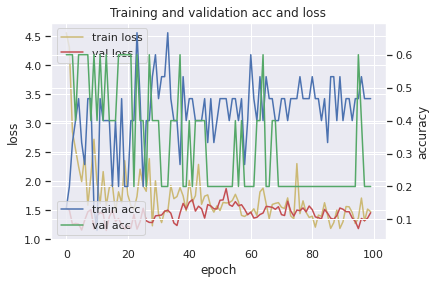

processing fold #: 1


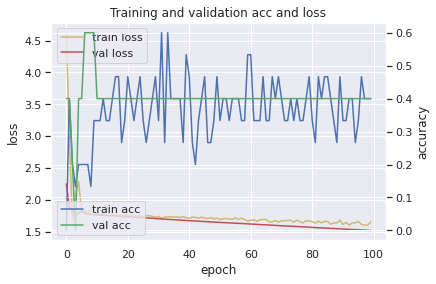

processing fold #: 2


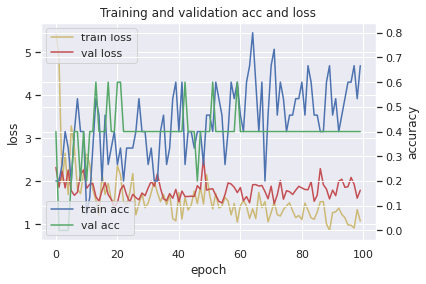

processing fold #: 3


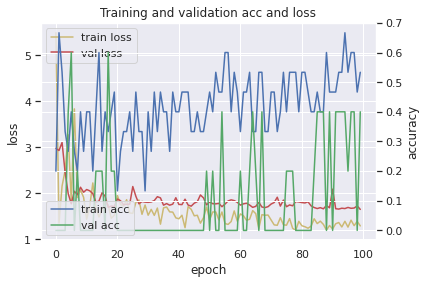

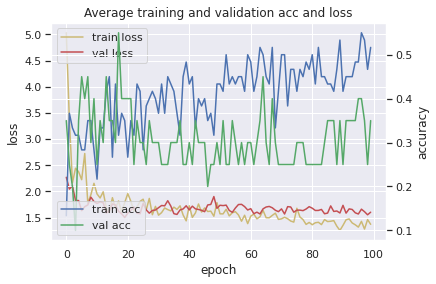

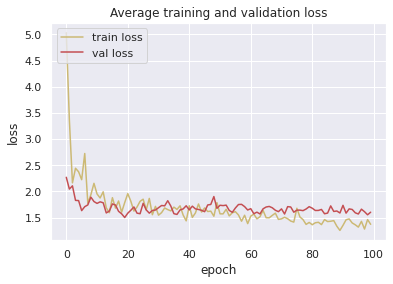

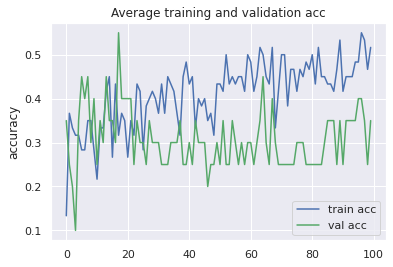

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 30)                7560      
_________________________________________________________________
dense_22 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 186       
Total params: 8,676
Trainable params: 8,676
Non-trainable params: 0
_________________________________________________________________


In [19]:
################################################################################
# : Neural network (Shallow neural network), Classification
################################################################################
"""
It showed about 40 % accuracy
"""
# Dataset
# Training set: 20(Harry:ENG13+GER7)
# Test set: 6(Harry:ENG4+GER2)

train_data = tr_dataset.copy()
test_data = te_dataset.copy()
train_label = dis_train_label.copy()
test_label = dis_test_label.copy()

train_label = to_categorical(train_label)
test_label = to_categorical(test_label)   

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []
all_val_acc_histories = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_label = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_label = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data=(val_data, val_label),
                        epochs = num_epochs, batch_size=5, verbose=0)

    # Shows the acc and loss plot
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    plt.title('Training and validation acc and loss')
    loss_ax.plot(history.history['loss'],'y',label = 'train loss')
    loss_ax.plot(history.history['val_loss'],'r',label = 'val loss')

    acc_ax.plot(history.history['acc'],'b',label = 'train acc')
    acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc = 'upper left')
    acc_ax.legend(loc = 'lower left')
    plt.show()

    # Save the histories: acc, loss, val_acc, and val_loss
    all_acc_histories.append(history.history['acc'])
    all_loss_histories.append(history.history['loss'])
    all_val_acc_histories.append(history.history['val_acc'])
    all_val_loss_histories.append(history.history['val_loss'])

# Compute the average histories
average_acc_history = [
            np.mean([x[i] for x in all_acc_histories])
            for i in range(num_epochs)]
average_loss_history = [
            np.mean([x[i] for x in all_loss_histories]) 
            for i in range(num_epochs)]
average_val_acc_history = [
            np.mean([x[i] for x in all_val_acc_histories]) 
            for i in range(num_epochs)]
average_val_loss_history = [
            np.mean([x[i] for x in all_val_loss_histories]) 
            for i in range(num_epochs)]

# Shows the average acc and loss plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
plt.title('Average training and validation acc and loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
acc_ax.plot(average_acc_history,'b',label = 'train acc')
acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')
plt.show()

# Shows the average loss plot
fig, loss_ax = plt.subplots()
plt.title('Average training and validation loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')
plt.show()

# Shows the average acc plot
fig, acc_ax = plt.subplots()
plt.title('Average training and validation acc')
acc_ax.plot(average_acc_history,'b',label = 'train acc')
acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 'lower right')
plt.show()

model.summary()

processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4


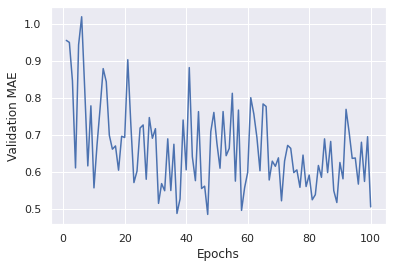

1/1 [==============================] - 0s 1ms/step - loss: 1.9775 - mae: 1.1487


In [16]:
################################################################################
# Nueral network, Regression: Choose the best model!
################################################################################


train_data = tr_dataset.copy()
test_data = te_dataset.copy()

# Define the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_scores = []
for i in range(k):
    print('processing fold #:', i+1)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_targets = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, vebose=0)
    # all_scores.append(val_mae)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

# Validation MAE Visualization
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Final model
model = build_model()
model.fit(train_data, train_label,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_label)

In [42]:
tr_bfi_data = tr_bfi.copy()
te_bfi_data = te_bfi.copy()
for i in range(124):
    tr_bfi_data = np.concatenate((tr_bfi_data, tr_bfi), axis = 1)
    te_bfi_data = np.concatenate((te_bfi_data, te_bfi), axis = 1)

print(tr_bfi_data.shape)
print(tr_arousal.shape)
print(tr_valence.shape)
print(te_bfi_data.shape)
print(te_arousal.shape)
print(te_valence.shape)
print(tr_label.shape)
print(te_label.shape)

tr_bfi_data3 = np.expand_dims(tr_bfi_data, axis=2)
te_bfi_data3 = np.expand_dims(te_bfi_data, axis=2)
tr_arousal_data3 = np.expand_dims(tr_arousal, axis=2)
te_arousal_data3 = np.expand_dims(te_arousal, axis=2)
tr_valence_data3 = np.expand_dims(tr_valence, axis=2)
te_valence_data3 = np.expand_dims(te_valence, axis=2)

print(tr_bfi_data3.shape)
print(te_bfi_data3.shape)
print(tr_arousal_data3.shape)
print(te_arousal_data3.shape)
print(tr_valence_data3.shape)
print(te_valence_data3.shape)
"""
tr_data = np.stack([tr_bfi_data3, tr_arousal_data3, tr_valence_data3], axis=2)
te_data = np.stack([te_bfi_data3, te_arousal_data3, te_valence_data3], axis=2)
"""
tr_data = np.stack([tr_bfi_data, tr_arousal, tr_valence], axis=2)
te_data = np.stack([te_bfi_data, te_arousal, te_valence], axis=2)
print(tr_data.shape)
print(te_data.shape)

(20, 125)
(20, 125)
(20, 125)
(6, 125)
(6, 125)
(6, 125)
(20, 1)
(6, 1)
(20, 125, 1)
(6, 125, 1)
(20, 125, 1)
(6, 125, 1)
(20, 125, 1)
(6, 125, 1)
(20, 125, 3)
(6, 125, 3)


processing fold #: 0


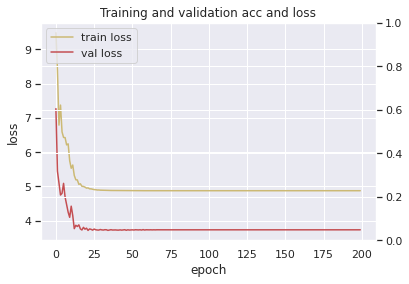

processing fold #: 1


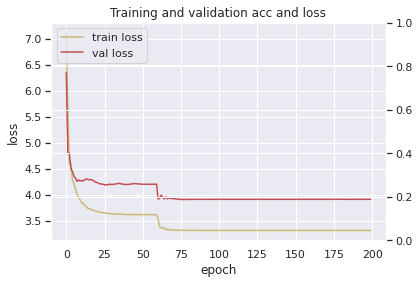

processing fold #: 2


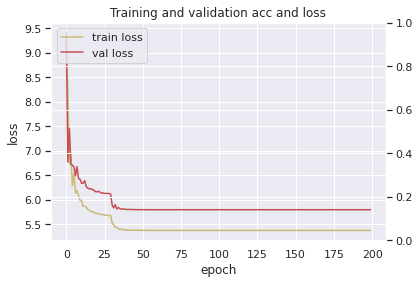

processing fold #: 3


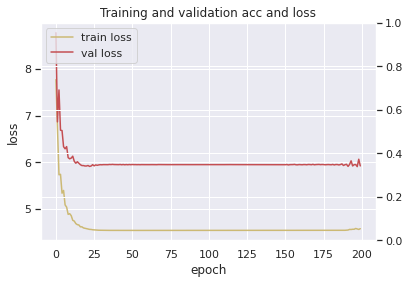

exprected_value 2.9110252809524537 real_value [3.23214286]
exprected_value 2.746221580505371 real_value [3.1547619]
exprected_value 2.5189759826660154 real_value [5.23809524]
exprected_value 2.565795650482178 real_value [4.14285714]
exprected_value 3.221517314910889 real_value [4.32142857]
exprected_value 2.88229962348938 real_value [3.86309524]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


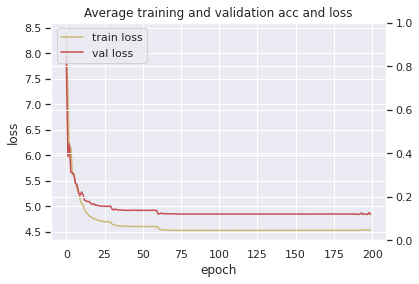

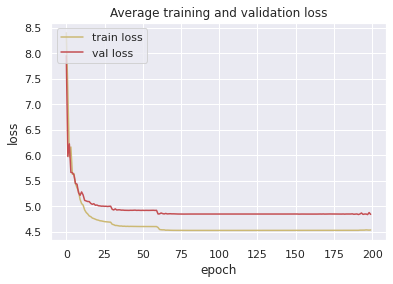

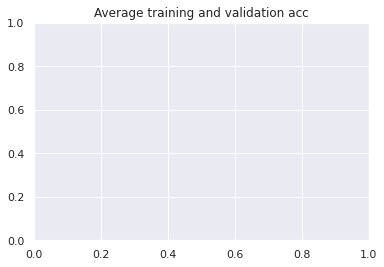

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 124, 64)           448       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                198450    
Total params: 198,898
Trainable params: 198,898
Non-trainable params: 0
_________________________________________________________________


In [43]:
################################################################################
# : Neural network (1D convolutional neural network), Sequential, Categorical
################################################################################
"""
Pending, CNN 1D technique and RNN applied

BFI_OPENNESS 251 generation needed

20trainingset, 251values, 1dimension
(20x251x1)
"""
# Dataset
# Training set: 20(Harry:ENG13+GER7)
# Test set: 6(Harry:ENG4+GER2)

train_data = tr_data.copy()
test_data = te_data.copy()
train_label = tr_label.copy()
test_label = te_label.copy()

def build_model():
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu',
                           input_shape=(125,3)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.compile(optimizer='adam',loss='mse')
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []
all_val_acc_histories = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_label = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_label = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data=(val_data, val_label),
                        epochs = num_epochs, batch_size=5, verbose=0)

    # Shows the acc and loss plot
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    plt.title('Training and validation acc and loss')
    loss_ax.plot(history.history['loss'],'y',label = 'train loss')
    loss_ax.plot(history.history['val_loss'],'r',label = 'val loss')

    #acc_ax.plot(history.history['acc'],'b',label = 'train acc')
    #acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc = 'upper left')
    #acc_ax.legend(loc = 'lower left')
    plt.show()

    # Save the histories: acc, loss, val_acc, and val_loss
    #all_acc_histories.append(history.history['acc'])
    all_loss_histories.append(history.history['loss'])
    #all_val_acc_histories.append(history.history['val_acc'])
    all_val_loss_histories.append(history.history['val_loss'])

result = model.predict(test_data, verbose=0)
for i, e in enumerate(result):
    print("exprected_value",sum(e,0.0)/len(e), "real_value", test_label[i])
#print( result)
#print(test_label)

# Compute the average histories
average_acc_history = [
            np.mean([x[i] for x in all_acc_histories])
            for i in range(num_epochs)]
average_loss_history = [
            np.mean([x[i] for x in all_loss_histories]) 
            for i in range(num_epochs)]
average_val_acc_history = [
            np.mean([x[i] for x in all_val_acc_histories]) 
            for i in range(num_epochs)]
average_val_loss_history = [
            np.mean([x[i] for x in all_val_loss_histories]) 
            for i in range(num_epochs)]

# Shows the average acc and loss plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
plt.title('Average training and validation acc and loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'upper left')
#acc_ax.legend(loc = 'lower left')
plt.show()

# Shows the average loss plot
fig, loss_ax = plt.subplots()
plt.title('Average training and validation loss')
loss_ax.plot(average_loss_history,'y',label = 'train loss')
loss_ax.plot(average_val_loss_history,'r',label = 'val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')
plt.show()

# Shows the average acc plot
fig, acc_ax = plt.subplots()
plt.title('Average training and validation acc')
#acc_ax.plot(average_acc_history,'b',label = 'train acc')
#acc_ax.plot(average_val_acc_history,'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc = 'lower right')
plt.show()

model.summary()

In [44]:
model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape =(125,3)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_data, train_label, epochs =100, verbose=0)
result = model.predict(test_data)
print(result)
print(test_label)
print(model.evaluate(test_data, test_label))

[[4.8174467]
 [3.6648786]
 [3.8521008]
 [3.6978378]
 [4.2125797]
 [3.8130918]]
[[3.23214286]
 [3.1547619 ]
 [5.23809524]
 [4.14285714]
 [4.32142857]
 [3.86309524]]
1/1 [==============================] - 0s 1ms/step - loss: 0.8178
0.8177967071533203


processing fold #: 1
processing fold #: 2
processing fold #: 3
processing fold #: 4


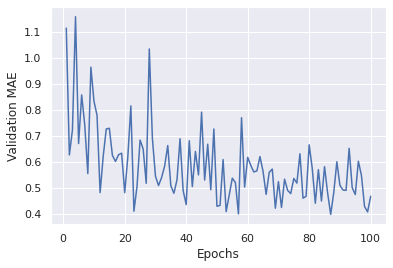

1/1 [==============================] - 0s 2ms/step - loss: 0.6731 - mae: 0.5762


In [46]:
################################################################################
# Nueral network, Regression: Choose the best model!
################################################################################


train_data = tr_dataset.copy()
test_data = te_dataset.copy()

# Define the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_scores = []
for i in range(k):
    print('processing fold #:', i+1)
    val_data = train_data[i*num_val_samples: (i + 1)*num_val_samples]
    val_targets = train_label[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    partial_train_targets = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_scores.append(mae_history)
    # val_mse, val_mae = model.evaluate(val_data, val_targets, vebose=0)
    # all_scores.append(val_mae)

average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]

# Validation MAE Visualization
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Final model
model = build_model()
model.fit(train_data, train_label,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_label)

In [54]:
result = model.predict(test_data)
for i,e in enumerate(result):
    print('predict_value: ',e, '\t','real_value',test_label[i])

predict_value:  [4.7089596] 	 real_value [3.23214286]
predict_value:  [3.413651] 	 real_value [3.1547619]
predict_value:  [3.9270756] 	 real_value [5.23809524]
predict_value:  [3.9256728] 	 real_value [4.14285714]
predict_value:  [4.278413] 	 real_value [4.32142857]
predict_value:  [3.7127888] 	 real_value [3.86309524]


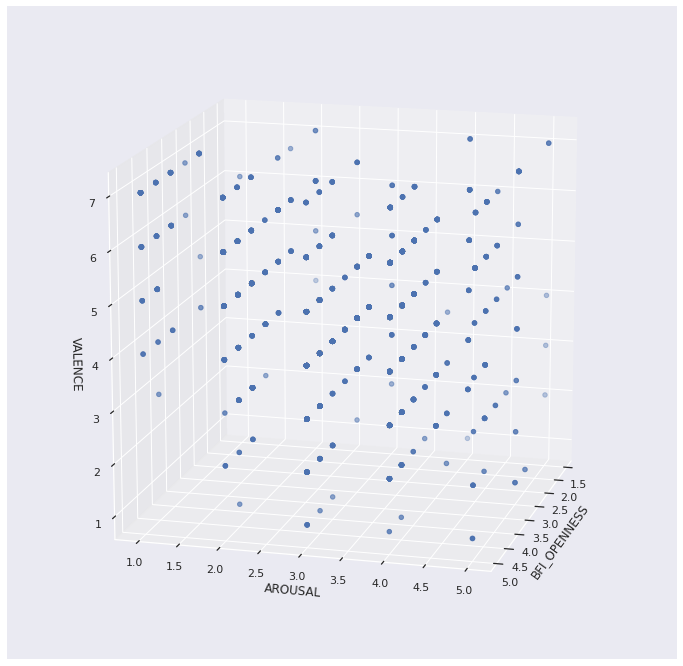

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# tr_data = np.stack([tr_bfi_data, tr_arousal, tr_valence], axis=2)
# te_data = np.stack([te_bfi_data, te_arousal, te_valence], axis=2)

xs = tr_bfi_data
ys = tr_arousal
zs = tr_valence

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('BFI_OPENNESS')
ax.set_ylabel('AROUSAL')
ax.set_zlabel('VALENCE')
ax.view_init(15, 15)

plt.show()

In [ ]:
#####################################################################################################
import keras
import numpyas np

X=np.arrange(-50,50,0.1)
Y=X*X+4

model = keras.models.Sequential()
model.add(keras.layers.Dense(1,input_shape(1,)))
keras.layers.Dense(1, input_shape(1,), activation='relu')
keras.layers.Dense(1, input_shape(1,), activation='softmax')

model.compile(loss="mse", optimizer='adam')
model.fi(X,Y,epochs=100)

In [ ]:
model.add(keras.layers.Dense(12,input_shape(3,), activation='relu'))
model.add(keras.layers.Dense(123, activation='relu'))
model.add(keras.layers.Dense(123, activation='relu'))
model.add(keras.layers.Dense(123, activation='relu'))
model.add(keras.layers.Dense(123, activation='relu'))
model.add(keras.layers.Dense(1))

Y = model.predict(X)

In [ ]:
# Perceptron
# Load the package
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# Generate Dataset
x_train = np.random.random((1000, 1))
y_train = x_train*2+np.random.random((1000, 1))/3.0
x_test = np.random.random((100,1))
y_test = x_test*2+np.random.random((100, 1))/3.0

# Build model
model = Sequential()
model.add(Dense(1, input_dim=1))
#model.add(Dense(1))

# Compile model
model.compile(optimizer='rmsprop',loss='mse')

# Train model
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)#print(model.get_weights())
#a,b,c,d = model.get_weights()
#print(a,b,c,d)
w, b = model.get_weights()
print(w, b)

# Plot training
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Evaluate model
loss = model.evaluate(x_test, y_test, batch_size = 32)
print('loss : ' + str(loss))

In [ ]:
# MLP
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

x_train = np.random.random((1000, 1))
y_train = x_train*2+np.random.random((1000,1))/3.0
x_test = np.random.random((100,1))
y_test = x_test*2+np.random.random((100,1))/3.0

model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : '+str(loss))

In [ ]:
# Deep MLP
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

x_train = np.random.random((1000,1))
y_train = x_train*2+np.random.random((1000,1))/3.0
x_test = np.random.random((100,1))
y_test = x_test*2+np.random.random((100,1))/3.0

model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

#matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss :' + str(loss))

In [ ]:
# Linear regression

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from mpl_toolkits.mplot3d import Axes3D

raw_data = np.genfromtxt('x09.txt', skip_header=36)

xs = np.array(raw_data[:2], dtype=np.float32)
ys = np.array(raw_data[:3], dtype=np.float32)
zs = np.array(raw_data[:4], dtype=np.float32)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('Weight')
ax.set_ylabel('Age')
ax.set_zlabel('Blood fat')
ax.view_init(15, 15)

plt.show()

import tenworflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.modles import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from mpl_toolkits.mplot3d import Axes3D

raw_data = np.genfromtxt('x09.txt', skip_header=36)

xs = np.array(raw_data[:2], dtype=np.float32)
ys = np.array(raw_data[:3], dtype=np.float32)
zs = np.array(raw_data[:4], dtype=np.float32)

x_data = np.array(raw_data[:,2:4], dtype=np.float32)
y_data = np.array(raw_data[:,4], dtype=np.float32)
y_data = y_data.reshape((25,1))

rmsprop = RMSprop(lr=0.01)
model = Sequential()
model.add(Dense(1,input_shape=(2,)))
model.compile(loss='mse', optimizer=rmsprop)
model.summary()

hist = model.fit(x_data, y_data, epochs=1000)

print(hist.history.keys())

print("100kg, 40 yr =", model.predict(np.array([100,40]).reshape(1,2)))
print("60kg, 25 yr =", model.predict(np.array([60,25]).reshpae(1,2)))

w_, b_ = model.get_weights()

x = np.linspace(20, 100, 50).reshpae(50,1)
y = np.linspace(10, 70, 50).reshape(50,1)

x = np.concatentate((x,y), axis =1)
z = np.matmul(X, W_)+ b_

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
ax.scatter(xs, ys, zs)
ax.set_xlael('weight')
ax.set_ylabel('Age')
ax.set_zlabel('Blood fat')
ax.view_init(15,15)

plt.show()

In [60]:
print(oh_lang)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 55, 102, 98, 48, 56, 59, 78, 79, 80, 81, 25, 34, 46]


In [72]:
train_arousal2 = []
train_valence2 = []

for i in case:
    for j in i:
        if i == tr_case:
            set = rh_set[rh_set['CASE']==j]
            set['SURVEY_ORDER'] = oh_lang
            new = set.sort_values(by='SURVEY_ORDER')
            train_arousal2.append(list(new.loc[:,['AROUSAL_RATING']]['AROUSAL_RATING']))
            train_valence2.append(list(new.loc[:,['VALENCE_RATING']]['VALENCE_RATING']))
            if j == 0:
                break
print(train_arousal2)
print(train_valence2)

[[2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 2.0, 4.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 2.0, 4.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 4.0, 2.0, 4.0, 4.0, 4.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0], [3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0, 4.0, 3.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


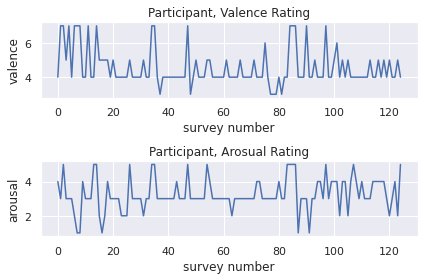

In [107]:
import numpy as np
import matplotlib.pyplot as plt

t = train_valence2[3]
s = train_arousal2[3]

plt.subplot(2, 1, 1)
plt.plot(t)
plt.xlabel('survey number')
plt.ylabel('valence')
plt.title('Participant, Valence Rating')
plt.grid(True)
"""
plt.annotate('local max', xy=(40, 4), xytext=(50, 6),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
"""
plt.subplot(2, 1, 2)
plt.plot(s)
plt.title('Participant, Arosual Rating')
plt.xlabel('survey number')
plt.ylabel('arousal')
plt.grid(True)
"""
plt.annotate('local max', xy=(40, 3), xytext=(50, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
"""
plt.tight_layout()
plt.show()